In [ ]:
# Cell 1: Imports and Setup
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import hellinger_fidelity
import qiskit_superstaq as qss

# Initialize Superstaq provider (Sorry Evan)
superstaq = qss.superstaq_provider.SuperstaqProvider(".....")  # Uses SUPERSTAQ_API_KEY environment variable or you can input your own


In [27]:
# Cell 2: Define Circuit Creation Functions
def create_circuit(name, num_qubits, operations):
    """Creates a quantum circuit with specified operations."""
    circuit = QuantumCircuit(num_qubits, name=name)
    for op in operations:
        getattr(circuit, op[0])(*op[1:])
    return circuit

def QC(qrg, crg, aux_circuit):
    """Constructs custom quantum circuit with auxiliary circuit."""
    q = QuantumCircuit(qrg, crg)
    q.h(0)
    q.h(1)
    q.h(2)
    q.s(1)
    q.z(0)
    q.p(np.pi / 2, 2)
    q.append(aux_circuit, range(3))
    q.p(np.pi / 2, 1)
    q.h(1)
    q.measure(qrg[1], crg[0])
    return q

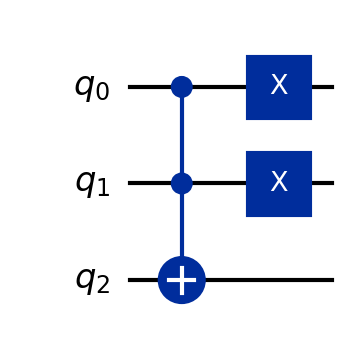

In [16]:
# Cell 3: Define Circuit Data
circuits_data = {
    "P0+": (3, [("id", 0), ("id", 1), ("id", 2)]),
    "P0-": (3, [("cx", 2, 1), ("x", 0), ("x", 1), ("x", 2), ("ccx", 2, 1, 0), ("x", 1), ("x", 2)]),
    "P1+": (3, [("ccx", 2, 1, 0), ("cx", 2, 1), ("x", 2)]),
    "P1-": (3, [("cx", 1, 0), ("x", 2)]),
    "P2+": (3, [("cx", 1, 0), ("x", 1)]),
    "P2-": (3, [("ccx", 2, 1, 0), ("cx", 2, 1), ("x", 1)]),
    "P3+": (3, [("cx", 2, 1), ("x", 0), ("x", 1), ("x", 2), ("ccx", 2, 1, 0)]),
    "P3-": (3, [("x", 1)]),
    "P4+": (3, [("x", 2)]),
    "P4-": (3, [("cx", 2, 1), ("x", 0), ("x", 1), ("x", 2), ("ccx", 2, 1, 0), ("x", 2), ("x", 1)]),
    "P5+": (3, [("ccx", 2, 1, 0), ("cx", 2, 1), ("x", 0), ("x", 2)]),
    "P5-": (3, [("x", 1), ("x", 2), ("cx", 1, 0), ("x", 1)]),
    "P6+": (3, [("x", 1), ("cx", 1, 0)]),
    "P6-": (3, [("ccx", 0, 1, 2), ("x", 1), ("x", 0)]),
    "P7+": (3, [("cx", 2, 1), ("x", 2), ("x", 1), ("ccx", 2, 1, 0)]),
    "P7-": (3, [("x", 2), ("x", 1), ("x", 0)]),
}

# Create circuits
circuits = {name: create_circuit(name, data[0], data[1]) for name, data in circuits_data.items()}

# Visualize example circuit
circuits["P6-"].draw('mpl', scale=1.5)

In [17]:
# Cell 4: Build Complete Quantum Circuits
num_qubits = 3
qrg = QuantumRegister(num_qubits, name="q")
crg = ClassicalRegister(1, name="cr")
qcs = []

for key in circuits_data.keys():
    aux_circuit = circuits[key]
    qc = QC(qrg, crg, aux_circuit)
    qcs.append(qc)

# Display first circuit
qcs[0].draw('mpl')
print(f"Total circuits created: {len(qcs)}")
print(f"Example circuit depth: {qcs[0].depth()}")

Total circuits created: 16
Example circuit depth: 6


In [ ]:
# Cell 5: Check Available Backends
backends = superstaq.backends()
print("Available backends:")
for backend in backends:
    print(f"  - {backend.name}")

# Select the accessible simulator
backend = superstaq.get_backend("ss_unconstrained_simulator")
print(f"\nSelected backend: {backend.name}")

Available backends:
  - aqt_keysight_qpu
  - aqt_zurich_qpu
  - aws_dm1_simulator
  - aws_sv1_simulator
  - aws_tn1_simulator
  - cq_sqale_qpu
  - cq_sqale_simulator
  - eeroq_wonderlake_qpu
  - ibmq_brisbane_qpu
  - ibmq_fez_qpu
  - ibmq_kingston_qpu
  - ibmq_marrakesh_qpu
  - ibmq_sherbrooke_qpu
  - ibmq_torino_qpu
  - ionq_aria-1_qpu
  - ionq_aria-2_qpu
  - ionq_forte-1_qpu
  - ionq_forte-enterprise-1_qpu
  - ionq_ion_simulator
  - iqm_garnet_qpu
  - qscout_peregrine_qpu
  - qtm_h1-1_qpu
  - qtm_h1-1e_simulator
  - qtm_h2-1_qpu
  - rigetti_ankaa-3_qpu
  - ss_unconstrained_simulator

Selected backend: ss_unconstrained_simulator


In [21]:
# Cell 6: Test with Small Circuit
# Test with a simple circuit first
test_qc = QuantumCircuit(2, 2)
test_qc.h(0)
test_qc.cx(0, 1)
test_qc.measure_all()

print("Testing simple circuit...")
job = backend.run(test_qc, shots=100, method="dry-run")
result = job.result()
counts = result.get_counts()
print(f"Test circuit counts: {counts}")

Testing simple circuit...
Test circuit counts: {'0000': 50, '1100': 50}


In [22]:
# Cell 7: Submit Jobs (Small Batch with Dry Run)
# Submit first few circuits as test using dry-run
test_circuits = qcs[:3]
jobs = []
results = []

for idx, circuit in enumerate(test_circuits):
    try:
        job = backend.run(circuit, shots=1024, method="dry-run")
        jobs.append(job)
        result = job.result()
        results.append(result)
        counts = result.get_counts()
        print(f"Circuit {idx} counts: {counts}")
    except Exception as e:
        print(f"Error with circuit {idx}: {e}")

Circuit 0 counts: {'1': 1024}
Circuit 1 counts: {'0': 1024}
Circuit 2 counts: {'1': 1024}


In [23]:
# Cell 8: Analyze Circuit Statistics
print("\nCircuit Statistics:")
for idx, circuit in enumerate(qcs[:5]):  # First 5 circuits
    print(f"\nCircuit {idx}:")
    print(f"  Depth: {circuit.depth()}")
    print(f"  Gate counts: {circuit.count_ops()}")
    print(f"  Total gates: {sum(circuit.count_ops().values())}")


Circuit Statistics:

Circuit 0:
  Depth: 6
  Gate counts: OrderedDict([('h', 4), ('p', 2), ('s', 1), ('z', 1), ('P0+', 1), ('measure', 1)])
  Total gates: 10

Circuit 1:
  Depth: 6
  Gate counts: OrderedDict([('h', 4), ('p', 2), ('s', 1), ('z', 1), ('P0-', 1), ('measure', 1)])
  Total gates: 10

Circuit 2:
  Depth: 6
  Gate counts: OrderedDict([('h', 4), ('p', 2), ('s', 1), ('z', 1), ('P1+', 1), ('measure', 1)])
  Total gates: 10

Circuit 3:
  Depth: 6
  Gate counts: OrderedDict([('h', 4), ('p', 2), ('s', 1), ('z', 1), ('P1-', 1), ('measure', 1)])
  Total gates: 10

Circuit 4:
  Depth: 6
  Gate counts: OrderedDict([('h', 4), ('p', 2), ('s', 1), ('z', 1), ('P2+', 1), ('measure', 1)])
  Total gates: 10


In [24]:
# Cell 9: Fidelity Analysis (Using Dry Run)
print("\nRunning fidelity test...")
if qcs:
    try:
        # Run same circuit twice
        job1 = backend.run(qcs[0], shots=1024, method="dry-run")
        job2 = backend.run(qcs[0], shots=1024, method="dry-run")
        
        result1 = job1.result()
        result2 = job2.result()
        
        counts1 = result1.get_counts()
        counts2 = result2.get_counts()
        
        fidelity = hellinger_fidelity(counts1, counts2)
        print(f"Hellinger fidelity between runs: {fidelity:.4f}")
    except Exception as e:
        print(f"Fidelity test error: {e}")


Running fidelity test...
Hellinger fidelity between runs: 1.0000


In [25]:
# Cell 10: Batch Processing All Circuits (Dry Run)
print("\nProcessing all circuits with dry run...")
all_results = []

for idx, circuit in enumerate(qcs):
    try:
        job = backend.run(circuit, shots=1024, method="dry-run")
        result = job.result()
        all_results.append(result)
        
        if idx < 5:  # Show first 5 results
            counts = result.get_counts()
            print(f"Circuit {idx}: {counts}")
    except Exception as e:
        print(f"Error with circuit {idx}: {e}")

print(f"\nSuccessfully processed {len(all_results)} circuits")


Processing all circuits with dry run...
Circuit 0: {'1': 1024}
Circuit 1: {'0': 1024}
Circuit 2: {'1': 1024}
Circuit 3: {'0': 1024}
Circuit 4: {'1': 1024}

Successfully processed 16 circuits


In [ ]:
# Cell 11: Run on Real Hardware (Remove dry-run when ready)
# WARNING: This will use credits!
"""
# Uncomment to run on real hardware
real_backend = superstaq.get_backend("ibmq_brisbane_qpu")  # or another available QPU
real_jobs = []

for idx in range(3):  # Only run first 3 to save credits
    job = real_backend.run(qcs[idx], shots=1024)  # No dry-run parameter
    real_jobs.append(job)
    print(f"Submitted real job {idx}: {job.job_id()}")

# Wait for results
import time
for job in real_jobs:
    while job.status() != 'DONE':
        time.sleep(10)
    result = job.result()
    print(f"Real hardware result: {result.get_counts()}")
"""

In [ ]:
# Cell 12: Save Results
# Save job IDs and results for later analysis
import json

results_data = {
    "job_ids": [job.job_id() for job in jobs],
    "circuit_names": list(circuits_data.keys())[:len(jobs)],
    "backend": backend.name()
}

with open('superstaq_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print("Results saved to superstaq_results.json")